In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import pandas as pd
import glob
import math
import subprocess
from matplotlib import colormaps

from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplcursors  

from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity

import numpy as np
from scipy.integrate import trapezoid

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

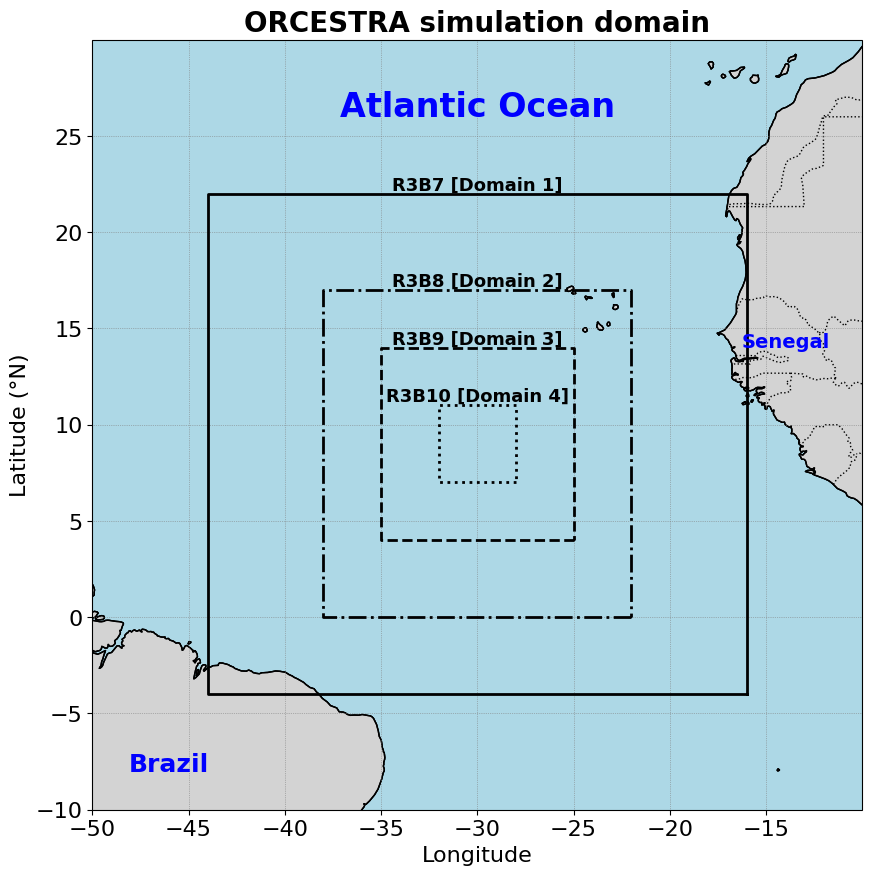

In [43]:
## ORCESTRA 3 Sept 2024 domain

lon1 = [-16., -44.];
lat1 = [-4., 22.];

lon2 = [-22., -38.];
lat2 = [-0., 17.];
#lat2 = [-0.85, 17.];

lon3 = [-25., -35.];
lat3 = [4, 14.];

lon4 = [-28., -32.];
lat4 = [7., 11.];


fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and features for context
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')


ax.plot([lon1[0], lon1[1], lon1[1], lon1[0], lon1[0]], 
        [lat1[0], lat1[0], lat1[1], lat1[1], lat1[0]], 
        color='black', linewidth=2, linestyle='-', transform=ccrs.PlateCarree())

ax.plot([lon2[0], lon2[1], lon2[1], lon2[0], lon2[0]], 
        [lat2[0], lat2[0], lat2[1], lat2[1], lat2[0]], 
        color='black', linewidth=2, linestyle='-.', transform=ccrs.PlateCarree())

ax.plot([lon3[0], lon3[1], lon3[1], lon3[0], lon3[0]], 
        [lat3[0], lat3[0], lat3[1], lat3[1], lat3[0]], 
        color='black', linewidth=2, linestyle='--', transform=ccrs.PlateCarree())

ax.plot([lon4[0], lon4[1], lon4[1], lon4[0], lon4[0]], 
        [lat4[0], lat4[0], lat4[1], lat4[1], lat4[0]], 
        color='black', linewidth=2, linestyle=':', transform=ccrs.PlateCarree())

ax.text(-30., 22.2, "R3B7 [Domain 1]", transform=ccrs.PlateCarree(), fontsize=13, ha='center', color='k', fontweight='bold')
ax.text(-30., 17.2, "R3B8 [Domain 2]", transform=ccrs.PlateCarree(), fontsize=13, ha='center', color='k', fontweight='bold')
ax.text(-30., 14.2, "R3B9 [Domain 3]", transform=ccrs.PlateCarree(), fontsize=13, ha='center', color='k', fontweight='bold')
ax.text(-30., 11.2, "R3B10 [Domain 4]", transform=ccrs.PlateCarree(), fontsize=13, ha='center', color='k', fontweight='bold')

ax.set_xlim(-50., -10.)
ax.set_ylim(-10., 30.)
ax.set_xticks(range(-50, -10, 5))  
ax.set_yticks(range(-10, 30, 5))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel("Longitude", fontsize=16)
ax.set_ylabel("Latitude (°N)", fontsize=16)
ax.grid(True, linestyle=':', linewidth=0.5, color='grey')
ax.set_title('ORCESTRA simulation domain', fontsize=20, fontweight='bold')

# Add oceans and continents features
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.text(-30, 26, "Atlantic Ocean", transform=ccrs.PlateCarree(), fontsize=24, fontweight='bold', ha='center', color='blue')
ax.text(-14, 14, "Senegal", transform=ccrs.PlateCarree(), fontsize=14, fontweight='bold', ha='center', color='blue')
ax.text(-46, -8, "Brazil", transform=ccrs.PlateCarree(), fontsize=18, fontweight='bold', ha='center', color='blue')

plt.show()

In [3]:

ds_4sip = xr.open_mfdataset('/work/bk1415/b382718/output/orcestra/nested_run/icon_output/marine_ccn/latent_heat/control/orcestra_2mom_sip/NWP_*.nc');
ds_nosip = xr.open_mfdataset('/work/bk1415/b382718/output/orcestra/nested_run/icon_output/marine_ccn/latent_heat/nosip/orcestra_2mom_nosip/NWP_*.nc');
ds_norf = xr.open_mfdataset('/work/bk1415/b382718/output/orcestra/nested_run/icon_output/marine_ccn/latent_heat/norf/orcestra_2mom_norf/NWP_*.nc');
ds_nohm = xr.open_mfdataset('/work/bk1415/b382718/output/orcestra/nested_run/icon_output/marine_ccn/latent_heat/nohm/orcestra_2mom_nohm/NWP_*.nc');
ds_nobr = xr.open_mfdataset('/work/bk1415/b382718/output/orcestra/nested_run/icon_output/marine_ccn/latent_heat/nobr/orcestra_2mom_nobr/NWP_*.nc');
ds_nosb = xr.open_mfdataset('/work/bk1415/b382718/output/orcestra/nested_run/icon_output/marine_ccn/latent_heat/nosb/orcestra_2mom_nosb/NWP_*.nc');


In [4]:

ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl

ds_norf['w_vel'] = -1.*ds_norf.omega/(9.8*ds_norf.rho)
ds_norf['tempc'] = ds_norf.temp-273.16;
ds_norf['lwc_gperm3']  = ds_norf.qc*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tqi'] = ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['tq'] = ds_norf.qc+ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['ciwc_gperm3'] = ds_norf.qi*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tiwc_gperm3'] = (ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh)*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['cdnc_percm3'] = ds_norf.qnc*ds_norf.rho*1.e-6  # perkg to percm3
ds_norf['inc_perl'] = (ds_norf.qni+ds_norf.qns+ds_norf.qng+ds_norf.qnh)*ds_norf.rho*1.e-3 # perkg to perl

ds_nohm['w_vel'] = -1.*ds_nohm.omega/(9.8*ds_nohm.rho)
ds_nohm['tempc'] = ds_nohm.temp-273.16;
ds_nohm['lwc_gperm3']  = ds_nohm.qc*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tqi'] = ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['tq'] = ds_nohm.qc+ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['ciwc_gperm3'] = ds_nohm.qi*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tiwc_gperm3'] = (ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh)*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['cdnc_percm3'] = ds_nohm.qnc*ds_nohm.rho*1.e-6  # perkg to percm3
ds_nohm['inc_perl'] = (ds_nohm.qni+ds_nohm.qns+ds_nohm.qng+ds_nohm.qnh)*ds_nohm.rho*1.e-3 # perkg to perl

ds_nobr['w_vel'] = -1.*ds_nobr.omega/(9.8*ds_nobr.rho)
ds_nobr['tempc'] = ds_nobr.temp-273.16;
ds_nobr['lwc_gperm3']  = ds_nobr.qc*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tqi'] = ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['tq'] = ds_nobr.qc+ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['ciwc_gperm3'] = ds_nobr.qi*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tiwc_gperm3'] = (ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh)*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['cdnc_percm3'] = ds_nobr.qnc*ds_nobr.rho*1.e-6  # perkg to percm3
ds_nobr['inc_perl'] = (ds_nobr.qni+ds_nobr.qns+ds_nobr.qng+ds_nobr.qnh)*ds_nobr.rho*1.e-3 # perkg to perl

ds_nosb['w_vel'] = -1.*ds_nosb.omega/(9.8*ds_nosb.rho)
ds_nosb['tempc'] = ds_nosb.temp-273.16;
ds_nosb['lwc_gperm3']  = ds_nosb.qc*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tqi'] = ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['tq'] = ds_nosb.qc+ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['ciwc_gperm3'] = ds_nosb.qi*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tiwc_gperm3'] = (ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh)*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['cdnc_percm3'] = ds_nosb.qnc*ds_nosb.rho*1.e-6  # perkg to percm3
ds_nosb['inc_perl'] = (ds_nosb.qni+ds_nosb.qns+ds_nosb.qng+ds_nosb.qnh)*ds_nosb.rho*1.e-3 # perkg to perl

In [5]:

grid_orc = xr.open_mfdataset('/work/bk1415/b382718/output/orcestra/nested_run/icon_output/marine_ccn/latent_heat/control/orcestra_2mom_sip/domain4_DOM04.nc');


clon_deg = np.degrees(grid_orc.clon)
clat_deg = np.degrees(grid_orc.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([-30., 9.])
#print(okla_x), print(okla_y)
dx_deg = 2.; dy_deg = 2.0
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

-32.03759442634206
-27.96236307373933
6.967468001138239
11.031985309167817
-32.0
-28.0
11.0
7.0


(None, None)

In [6]:

window_cell = (
    (grid_orc.clat >= np.deg2rad(bottom_bound))
    & (grid_orc.clat <= np.deg2rad(top_bound))
    & (grid_orc.clon >= np.deg2rad(left_bound))
    & (grid_orc.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)


# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_orc.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_orc.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)

vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}


def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid



window_vertex_indices :: [    4     7    15 ... 37370 37371 37372]
window_edge_indices :: [    63     64     65 ... 111329 111330 111331]


In [7]:

new_grid_orc = reindex_grid(grid_orc, selected_indices, vars_to_renumber)
mask=np.isin(ds_4sip['ncells'], selected_indices.cell)

ds_nosip_new = ds_nosip.sel(ncells=mask)
ds_4sip_new = ds_4sip.sel(ncells=mask)
ds_norf_new = ds_norf.sel(ncells=mask)
ds_nohm_new = ds_nohm.sel(ncells=mask)
ds_nobr_new = ds_nobr.sel(ncells=mask)
ds_nosb_new = ds_nosb.sel(ncells=mask)


In [8]:

def calc_dewpoint(tempc, rh):
    dewpoint = tempc - ((100. - rh)/5.)
    return dewpoint


def calc_tdew(t, rh):        # Magnus-Tetens approximation
    a = 17.27; b = 237.7;
    alpha = (a*t/(b+t)) + np.log(rh/100)
    td = b*alpha/(a-alpha)
    return td
    
def calc_vir_temp(tc, q):
    #virt_tempk_wk = t/(1. - (ev/p)*(1-0.622))
    temp = tc + (1-0.622*q)
    return temp
    
def calculate_lcl(pressure, temperature, dewpoint):
    l = np.argmin(np.abs(temperature - dewpoint))
    return pressure[l], temperature[l]

def calc_lcl(t, td):
    lcl = td + 125.*(t-td)
    return lcl
    
def e_sat_hpa(tc):
    e_sat_pa = 6.112*np.exp((17.67*tc)/(tc+243.5))
    return e_sat_pa

def calc_parcel_temp(pres, ht, q_sat, tk_lcl):
    grav = 9.8  # acceleration due to gravity [m/s^2]
    eps = 0.622  # ratio of the gas constants for water vapor and dry air
    Rd = 287.  # specific gas constant for dry air [J/(kg*K)]
    cp = 1005.  # specific heat capacity at constant pressure for dry air [J/(kg*K)]
    lv = 2.5e6  # latent heat of vaporization [J/kg]
    Rv = 461.  # specific gas constant for water vapor [J/(kg*K)]

    tk_parcel = np.zeros(len(ht))  
    del_t_par = np.zeros(len(ht))  

    tk_parcel[0] = tk_lcl + 273.15 
    
    for i in range(1, len(ht)):
        dht = ht[i] - ht[i - 1]  
        qs = q_sat[i]  
        term_a = 1. + lv * qs / (Rd * tk_parcel[i - 1])
        term_b = (lv ** 2.) * eps * qs
        term_c = Rd * (tk_parcel[i - 1]) ** 2.
        
        del_t_par[i] = grav * term_a / (cp + (term_b / term_c))

        tk_parcel[i] = tk_parcel[i - 1] - del_t_par[i] * dht
        
    tempc = tk_parcel - 273.15
    return tempc

import numpy as np



def calc_cape(pres, t_env, t_par, tv_env, tv_par):
    """
    Calculate Convective Available Potential Energy (CAPE).
    
    Parameters:
        pres (array): Pressure levels (hPa or Pa).
        t_env (array): Environmental temperature (°C).
        t_par (array): Parcel temperature (°C).
        tv_env (array): Environmental virtual temperature (°C).
        tv_par (array): Parcel virtual temperature (°C).
    
    Returns:
        cape (float): CAPE value (J/kg).
    """
    Rd = 287.0  # gas constant for dry air (J/kg/K)
    
    # Convert temperatures to Kelvin
    tk_env = t_env + 273.15
    tk_v_env = tv_env + 273.15
    tk_par = t_par + 273.15
    tk_v_par = tv_par + 273.15
    
    cape = 0.0
    
    # Loop through pressure levels
    for i in range(1, len(pres)):
        # Check if parcel is warmer than the environment
        if tk_v_par[i] > tk_v_env[i]:
            # Calculate logarithmic pressure difference
            dlnp = np.log(pres[i-1] / pres[i])
            cape = cape + Rd * (tk_v_par[i] - tk_v_env[i]) * dlnp
    return cape
        

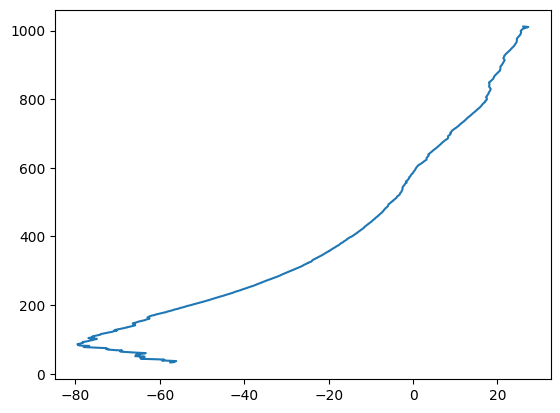

In [10]:
file_path = '/work/bk1415/b382718/output/orcestra/observations/wyoming_sonde/sonde_orcestra_20240903_1200UTC'
column_names = ['pres', 'height', 'temp', 'Tdew', 'relhum', 'qv', 'w_dir', 'w_wind', 'theta', 'theta_e', 'theta_v']


# Specify invalid values (strings or other markers for missing data)
invalid_values = ['-----------------------------------------------------------------------------', '9999.0', '999.0']

# Read the data and replace invalid values with NaN
ds_sonde = pd.read_csv(file_path, sep='\s+', skiprows=6, names=column_names, na_values=invalid_values)

# drop rows with NaN values if needed
ds_sonde.dropna(inplace=True)


temp_sonde = ds_sonde.temp.values
pres_sonde = ds_sonde.pres.values
tdew_sonde = ds_sonde.Tdew.values
rh_sonde = ds_sonde.relhum.values
qv_sonde = ds_sonde.qv.values
w_sonde = ds_sonde.w_wind.values
ht_sonde = ds_sonde.height.values

plt.plot(temp_sonde, pres_sonde)

In [12]:
ds_4sip.time[24]

<xarray.DataArray 'time' ()>
array('2024-09-03T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2024-09-03T12:00:00
Attributes:
    standard_name:  time
    axis:           T

Tenv    ::  [ 25.472301   25.102497   24.697054   24.264956   23.847887   23.441639
  23.044283   22.65701    22.262733   21.851585   21.42618    20.985214
  20.5164     20.013956   19.469633   18.894772   18.294472   17.667616
  17.003273   16.33308    15.616732   14.869071   14.097094   13.298925
  12.463171   11.583893   10.66444     9.718272    8.737001    7.729309
   6.6857643   5.6324406   4.5390754   3.3691444   2.157193    0.9753825
  -0.1675019  -1.4445887  -2.7727835  -4.1448     -5.607413   -7.155437
  -8.803791  -10.689388  -12.701304  -14.897587  -17.16448   -19.48239
 -21.997797  -24.785824  -27.889805  -31.305443  -34.981346  -38.979004
 -43.344913  -48.040936  -53.05474   -58.342712  -63.43048   -67.92141
 -72.30739   -76.134026  -78.61002   -70.58618   -63.699135 ]
Tparcel ::  [ 2.34416389e+01  2.33515918e+01  2.32197732e+01  2.30573637e+01
  2.28685845e+01  2.26558342e+01  2.24206675e+01  2.21641810e+01
  2.18870746e+01  2.15897641e+01  2.12725122e+01  2.09354437e+01


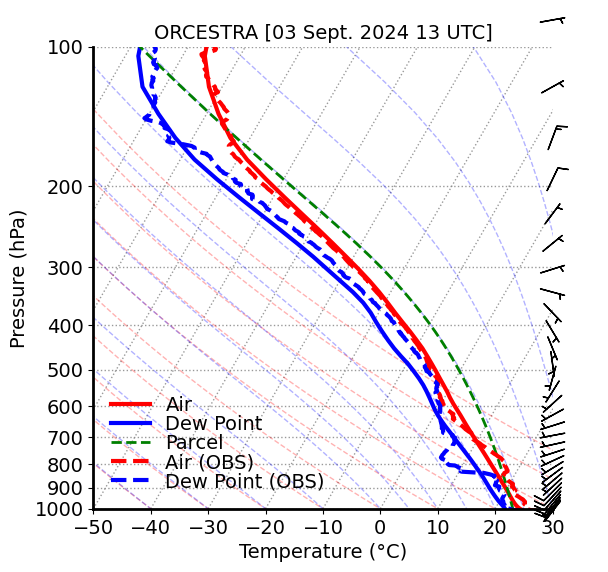

In [11]:

ds_skewt = ds_4sip.sel(time=ds_4sip.time[24])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)
#temp_dew = calc_tdew(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
#lcl_temp = calc_lcl(avg_tempc[0], avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, 1.5*q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, 1.5*q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('Tenv    :: ', avg_tempc)
print('Tparcel :: ', parcel_temp)
print('LCL :: ', lcl_temp)
print('CAPE :: ',parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 6))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
#skew.plot(avg_pres, calc_dewpoint(avg_tempc, avg_rh), 'b-.', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)

skew.plot(pres_sonde* units.hPa, temp_sonde* units.degC, 'r--', label='Air (OBS)', linewidth=lnwdth)
skew.plot(pres_sonde* units.hPa, tdew_sonde* units.degC, 'b--', label='Dew Point (OBS)', linewidth=lnwdth)

# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 30)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('ORCESTRA [03 Sept. 2024 13 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

<xarray.DataArray 'time' ()>
array('2024-09-03T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2024-09-03T01:00:00
Attributes:
    standard_name:  time
    axis:           T
CAPE ::  996.8746083481119 joule / kilogram
CIN ::  -0.8634835284170282 joule / kilogram


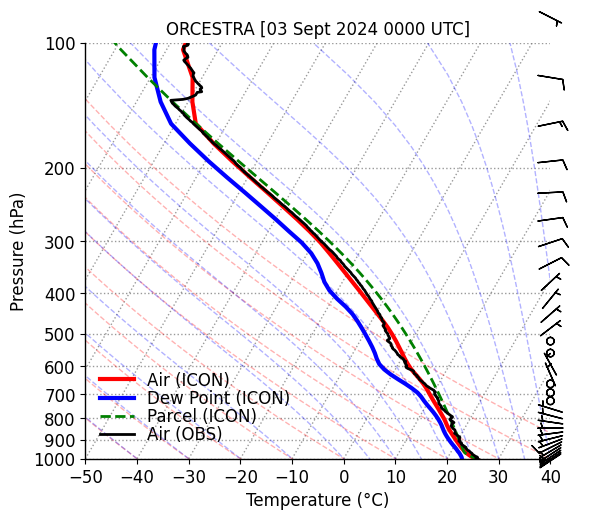

In [16]:
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from metpy.calc import parcel_profile
from metpy.calc import cape_cin



### Obs
file_path = '/work/bk1415/b382718/output/orcestra/observations/wyoming_sonde/sonde_orcestra_20240903_0000UTC'
column_names = ['pres', 'height', 'temp', 'Tdew', 'relhum', 'qv', 'w_dir', 'w_wind', 'theta', 'theta_e', 'theta_v']


# Specify invalid values (strings or other markers for missing data)
invalid_values = ['-----------------------------------------------------------------------------', '9999.0', '999.0']

# Read the data and replace invalid values with NaN
ds_sonde = pd.read_csv(file_path, sep='\s+', skiprows=6, names=column_names, na_values=invalid_values)

ds_sonde.dropna(inplace=True)

temp_sonde = ds_sonde.temp.values
pres_sonde = ds_sonde.pres.values
tdew_sonde = ds_sonde.Tdew.values
rh_sonde = ds_sonde.relhum.values
qv_sonde = ds_sonde.qv.values
w_sonde = ds_sonde.w_wind.values
ht_sonde = ds_sonde.height.values
### end obs

### ICON
ds_skewt = ds_4sip.sel(time=ds_4sip.time[2])

print(ds_4sip.time[2])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

### Parcel properties from ICON
temperature_K = (avg_tempc + 273.15) * units.K
relative_humidity = avg_rh / 100.0  # Convert to fraction

dewpoint = dewpoint_from_relative_humidity(temperature_K, relative_humidity)
avg_dewtempc = dewpoint.magnitude #- 273.15

pressure = avg_pres * units.hPa
temperature = avg_tempc * units.degC
dewpoint = avg_dewtempc * units.degC

parcel_tempk = parcel_profile(pressure, temperature[0], dewpoint[0])  # First level
parcel_tempc = parcel_tempk.magnitude-273.15

parcel_tempc = parcel_tempc * units.degC
cape, cin = cape_cin(pressure, temperature, dewpoint, parcel_tempc)

print('CAPE :: ', cape)
print('CIN :: ', cin)
### End parcel properties
### End ICON

# Create the Skew-T plot
fontsize=12;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, parcel_tempc, 'g--', label='Parcel (ICON)', linewidth=lnwdth-1)
skew.plot(pres_sonde* units.hPa, temp_sonde* units.degC, 'k-', label='Air (OBS)', linewidth=lnwdth-1)

# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 40)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('ORCESTRA [03 Sept 2024 0000 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.show()


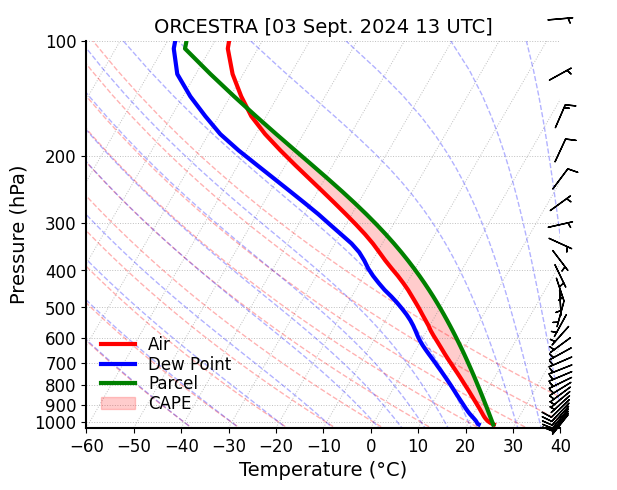

In [87]:
ds_skewt = ds_4sip.sel(time=ds_4sip.time[26])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)
#temp_dew = calc_tdew(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 5))
skew = SkewT(fig)

skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)

skew.plot_dry_adiabats(linewidth=1, alpha=alpha, linestyle='--')
skew.plot_moist_adiabats(linewidth=1, alpha=alpha, linestyle='--')

moist_adiabats = skew.moist_adiabats

# Now, we'll plot parcel path (that follows moist adiabatic line between LFC and LNB)
# We basically skip calculation of parcel temperature and CAPE and make use of the SKEWT plot itself

adiabat_profiles = []
for path in moist_adiabats.get_paths():
    temp_pres = path.vertices
    # We now interpolate temp_pres on available pressure levels
    adiabat_temp = np.interp(avg_pres, 
                           temp_pres[:,1][::-1],  # Pressure values
                           temp_pres[:,0][::-1])  # Temperature values
    adiabat_profiles.append(adiabat_temp)

# Find intersections between environmental temp and moist adiabats (these intersection points are LFC and LNB)
crossing_points = []
for i in range(len(avg_pres)-1):
    for j, adiabat in enumerate(adiabat_profiles):
        if ((avg_tempc[i] > adiabat[i] and avg_tempc[i+1] <= adiabat[i+1]) or 
            (avg_tempc[i] < adiabat[i] and avg_tempc[i+1] >= adiabat[i+1])):
            crossing_points.append((i, j))

# Process crossing points to find LFC and LNB
if len(crossing_points) >= 2:
    # Sort by pressure (descending)
    crossing_points.sort(key=lambda x: avg_pres[x[0]], reverse=True)
    
    lfc_idx, lfc_adiabat_idx = crossing_points[0]
    lnb_idx, lnb_adiabat_idx = crossing_points[-1]
    
    # Create parcel temperature line
    parcel_temp = np.full_like(avg_tempc, np.nan)
    parcel_temp[lfc_idx:lnb_idx+1] = adiabat_profiles[lfc_adiabat_idx][lfc_idx:lnb_idx+1]
    
    # Plot parcel path
    skew.plot(avg_pres, parcel_temp, 'g-', linewidth=lnwdth, label='Parcel')
    
    # Shade CAPE area
    skew.ax.fill_betweenx(avg_pres[lfc_idx:lnb_idx+1],
                        avg_tempc[lfc_idx:lnb_idx+1],
                        parcel_temp[lfc_idx:lnb_idx+1],
                        where=parcel_temp[lfc_idx:lnb_idx+1] > avg_tempc[lfc_idx:lnb_idx+1],
                        color='red', alpha=0.2, label='CAPE')

    # Mark LFC and LNB
    skew.plot(avg_pres[lfc_idx], avg_tempc[lfc_idx], 'k', markersize=10, markeredgewidth=2)#, label='LFC')
    skew.plot(avg_pres[lnb_idx], avg_tempc[lnb_idx], 'k', markersize=10, markeredgewidth=2)#, label='LNB')
    
    # Add text labels
    #plt.text(avg_tempc[lfc_idx]-2, avg_pres[lfc_idx]-10, 'LFC', 
    #        fontsize=fontsize-2, ha='right', va='top')
    #plt.text(avg_tempc[lnb_idx]+2, avg_pres[lnb_idx]+10, 'LNB', 
    #        fontsize=fontsize-2, ha='left', va='bottom')

# Add wind barbs if available
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Configure plot appearance
ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-60, 40)
ax.set_ylim(avg_pres[0]+20, 100)
ax.tick_params(axis='both', labelsize=fontsize-2)

plt.title('ORCESTRA [03 Sept. 2024 13 UTC]', fontsize=fontsize)#, pad=20)

plt.legend(frameon=False, handlelength=2, labelspacing=0.1, fontsize=fontsize-2, loc='lower left')#, bbox_to_anchor=(0.7, 0.95))

plt.grid(True, linestyle=':', linewidth=0.7, color='grey', alpha=0.5)

# Clean up borders
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


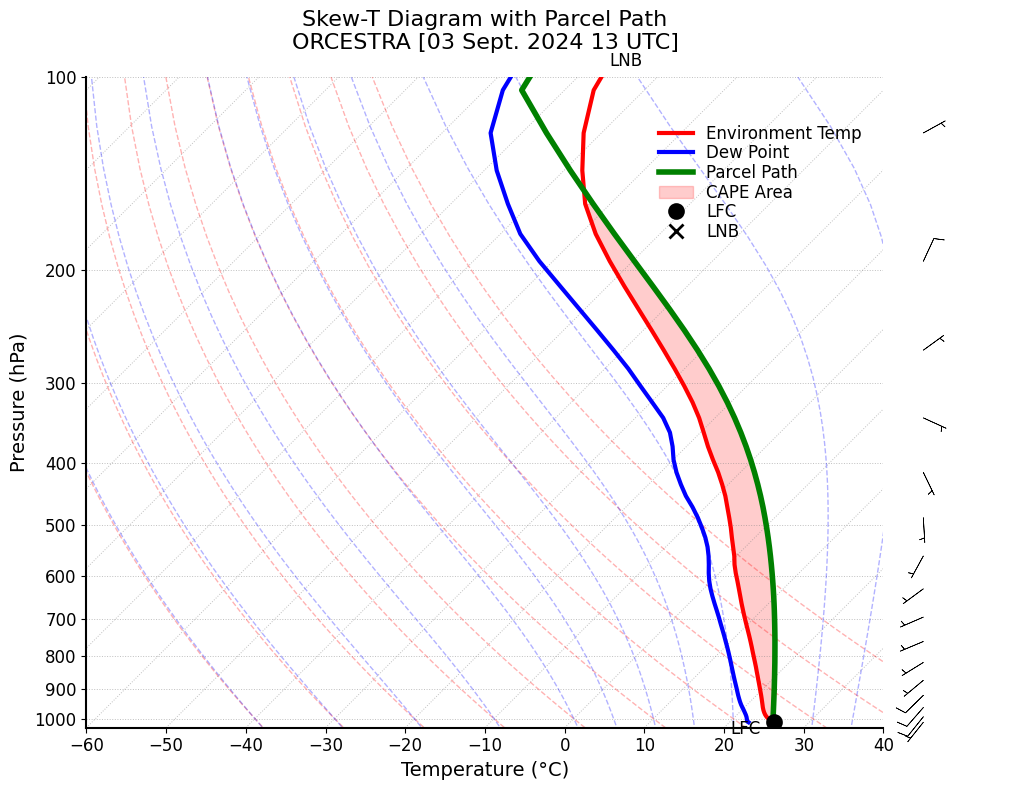

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT

# Assuming you've already calculated these arrays from your dataset:
# avg_pres, avg_tempc, avg_dewtempc, etc.

# Create the Skew-T plot
fontsize = 14
lnwdth = 3
alpha = 0.3

fig = plt.figure(figsize=(10, 8))
skew = SkewT(fig, rotation=45)

# Plot environmental temperature and dew point
skew.plot(avg_pres, avg_tempc, 'r-', label='Environment Temp', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)

# Add adiabats (must plot them first to access later)
skew.plot_dry_adiabats(linewidth=1, alpha=alpha, linestyle='--')
skew.plot_moist_adiabats(linewidth=1, alpha=alpha, linestyle='--')

# Get moist adiabats from the plot
moist_adiabats = skew.moist_adiabats

# Extract temperature values from adiabat paths
adiabat_profiles = []
for path in moist_adiabats.get_paths():
    temp_pres = path.vertices
    # Interpolate to our pressure levels (pressure is y-axis)
    adiabat_temp = np.interp(avg_pres, 
                           temp_pres[:,1][::-1],  # Pressure values
                           temp_pres[:,0][::-1])  # Temperature values
    adiabat_profiles.append(adiabat_temp)

# Find intersections between environmental temp and moist adiabats
crossing_points = []
for i in range(len(avg_pres)-1):
    for j, adiabat in enumerate(adiabat_profiles):
        if ((avg_tempc[i] > adiabat[i] and avg_tempc[i+1] <= adiabat[i+1]) or 
            (avg_tempc[i] < adiabat[i] and avg_tempc[i+1] >= adiabat[i+1])):
            crossing_points.append((i, j))

# Process crossing points to find LFC and LNB
if len(crossing_points) >= 2:
    # Sort by pressure (descending)
    crossing_points.sort(key=lambda x: avg_pres[x[0]], reverse=True)
    
    lfc_idx, lfc_adiabat_idx = crossing_points[0]
    lnb_idx, lnb_adiabat_idx = crossing_points[-1]
    
    # Create parcel temperature line
    parcel_temp = np.full_like(avg_tempc, np.nan)
    parcel_temp[lfc_idx:lnb_idx+1] = adiabat_profiles[lfc_adiabat_idx][lfc_idx:lnb_idx+1]
    
    # Plot parcel path
    skew.plot(avg_pres, parcel_temp, 'g-', linewidth=lnwdth+1, label='Parcel Path')
    
    # Shade CAPE area
    skew.ax.fill_betweenx(avg_pres[lfc_idx:lnb_idx+1],
                        avg_tempc[lfc_idx:lnb_idx+1],
                        parcel_temp[lfc_idx:lnb_idx+1],
                        where=parcel_temp[lfc_idx:lnb_idx+1] > avg_tempc[lfc_idx:lnb_idx+1],
                        color='red', alpha=0.2, label='CAPE Area')
    
    # Mark LFC and LNB
    skew.plot(avg_pres[lfc_idx], avg_tempc[lfc_idx], 'ko', 
             markersize=10, markeredgewidth=2, label='LFC')
    skew.plot(avg_pres[lnb_idx], avg_tempc[lnb_idx], 'kx', 
             markersize=10, markeredgewidth=2, label='LNB')
    
    # Add text labels
    plt.text(avg_tempc[lfc_idx]-2, avg_pres[lfc_idx]-10, 'LFC', 
            fontsize=fontsize-2, ha='right', va='top')
    plt.text(avg_tempc[lnb_idx]+2, avg_pres[lnb_idx]+10, 'LNB', 
            fontsize=fontsize-2, ha='left', va='bottom')

# Add wind barbs if available
if 'avg_u' in locals() and 'avg_v' in locals():
    n = max(1, len(avg_pres)//15)  # Plot every nth level
    skew.plot_barbs(avg_pres[::n], avg_u[::n], avg_v[::n], 
                   xloc=1.05, length=6, linewidth=0.5)

# Configure plot appearance
ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-60, 40)
ax.set_ylim(avg_pres[0]+20, 100)
ax.tick_params(axis='both', labelsize=fontsize-2)

plt.title('Skew-T Diagram with Parcel Path\nORCESTRA [03 Sept. 2024 13 UTC]', 
         fontsize=fontsize+2, pad=20)

plt.legend(frameon=False, handlelength=2, labelspacing=0.1, 
          fontsize=fontsize-2, loc='upper left', bbox_to_anchor=(0.7, 0.95))

plt.grid(True, linestyle=':', linewidth=0.7, color='grey', alpha=0.5)

# Clean up borders
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
